In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

This project looks at batting data at a player level from the 2023 MLB season. RBI's have recently been considerred to an outdated statistic. 
I want to see if there is any latent features that are indicative a certain ranges of RBI. 

Dataset was obtained from https://www.kaggle.com/datasets/vivovinco/2023-mlb-player-stats

In [3]:
df_batting = pd.read_excel('C:/Users/Jacob Goes/Documents/ML_Course2_Final/2023_MLB_Player_Batting.xlsx')

In [4]:
print(df_batting)
print(df_batting.columns)



      Rk               Name  Age   Tm  Lg   G   PA   AB   R    H  ...    OBP  \
0      1         CJ�Abrams*   22  WSN  NL  89  340  316  47   82  ...  0.306   
1      2          Jos�Abreu   36  HOU  AL  95  400  368  33   90  ...  0.293   
2      3   Ronald�Acuna�Jr.   25  ATL  NL  97  446  391  86  129  ...  0.408   
3      4       Willy�Adames   27  MIL  NL  89  383  336  44   71  ...  0.291   
4      5        Riley�Adams   27  WSN  NL  23   87   79   4   22  ...  0.337   
..   ...                ...  ...  ...  ..  ..  ...  ...  ..  ...  ...    ...   
690  691  Masataka�Yoshida*   29  BOS  AL  86  370  335  52  107  ...  0.381   
691  692        Alex�Young*   29  CIN  NL   2    0    0   0    0  ...  0.000   
692  693       Jared�Young*   27  CHC  NL  13   39   35   7    6  ...  0.256   
693  694        Seby�Zavala   29  CHW  AL  59  156  143  14   23  ...  0.208   
694  695        Mike�Zunino   32  CLE  AL  42  140  124  11   22  ...  0.271   

       SLG    OPS  OPS+   TB  GDP  HBP 

In [5]:
df_batting.drop(['Tm','Name','Age','Lg','G','SB','CS','OPS','OPS+','TB'],axis=1,inplace=True)
print(df_batting)

      Rk   PA   AB   R    H  2B  3B  HR  RBI  BB  SO     BA    OBP    SLG  \
0      1  340  316  47   82  17   4  10   39  13  72  0.259  0.306  0.434   
1      2  400  368  33   90  16   0   8   50  24  92  0.245  0.293  0.353   
2      3  446  391  86  129  26   1  23   58  49  53  0.330  0.408  0.578   
3      4  383  336  44   71  16   0  17   48  37  98  0.211  0.291  0.411   
4      5   87   79   4   22   5   2   3   10   6  26  0.278  0.337  0.506   
..   ...  ...  ...  ..  ...  ..  ..  ..  ...  ..  ..    ...    ...    ...   
690  691  370  335  52  107  22   3  11   51  28  42  0.319  0.381  0.501   
691  692    0    0   0    0   0   0   0    0   0   0  0.000  0.000  0.000   
692  693   39   35   7    6   0   2   1    5   3  11  0.171  0.256  0.371   
693  694  156  143  14   23   3   0   6   15   8  60  0.161  0.208  0.308   
694  695  140  124  11   22   7   0   3   11  15  61  0.177  0.271  0.306   

     GDP  HBP  SH  SF  IBB  
0      5    8   3   0    0  
1     11    3   0

For relevance in predicting RBI, league is not relevant since the adoption of the DH in both leagues.
Games played does not add info outside of at-bats or plate apperances. Stolen bases and caught stealing are not relevant to that player's RBI
OPS and OPS+ have representation in OBP and SLG, making them redundant, and TB is accounted for in AB and SLG

Additionally, since RBI relies on teammates outside of a HR, team environment may be represented by runs despite little direct correlation with RBI

Text(0.5, 1.0, 'Histogram of Players with RBI totals')

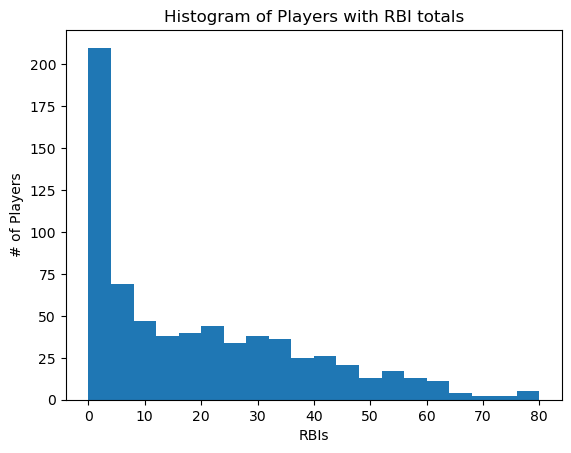

In [7]:
plt.hist(df_batting['RBI'],bins=20)
plt.xlabel('RBIs')
plt.ylabel('# of Players')
plt.title('Histogram of Players with RBI totals')

Observing the Histogram of RBI, a few things are immediately noticable. First, nearly a third of players have 8 or less RBI's.
I believe removing them wouldn't affect the results too much since they are likely very low on playing time, which could obscure more relevant
features delineating RBI totals for more active players. 
Based on visual inspection, there are roughly 6-7 peaks in the histogram, which could be a good number of clusters to set for k-means clustering.
Removing the low-RBI players opens and reducing the bins to 7



Text(0.5, 1.0, 'Histogram of Players with RBI totals')

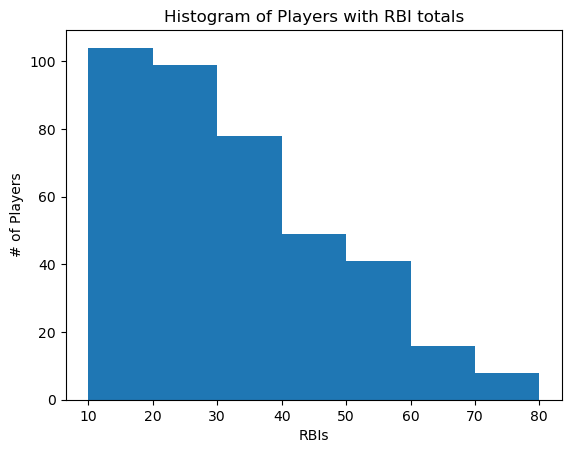

In [9]:
df_batting_gt10_rbi = df_batting[df_batting.RBI >= 10]
plt.hist(df_batting_gt10_rbi['RBI'],bins=7)
plt.xlabel('RBIs')
plt.ylabel('# of Players')
plt.title('Histogram of Players with RBI totals')

This histogram looks like it is more managable for this dataset, and I belive I will compare 5-8 clusters to determine what is the best

Here is where the dimensionality reduction comes into play, and I will explain what features I can see.
Opportunity (RBI opportunities), which I think encompases PA, AB, and potentially R.
Execution, which encompases H, 2B, 3B, HR, BA, SLG, and to a lesser extent BB, HBP, and OBP.
Failures, which encompases SO, GDP, and to a lesser extent SF.
Avoidance, which encompases IBB and to a lesser extent BB, HBP, and OBP.
Extra Base Hits, which includes 2B, 3B, and HR.
I think I will reduce dimensionality to 5 to account for these groups

Here we will build the model and train on the dataset

In [13]:
#Assignment of players to clusters based on RBI Total
RBIs = df_batting_gt10_rbi['RBI']
RBIs = np.array(RBIs)
print(RBIs)

hist, bin_edges_7_clust = np.histogram(RBIs, bins=7)



print(bin_edges_7_clust)



clust_7_group = np.zeros(len(RBIs))



for i in range(len(RBIs)):
    if RBIs[i] <= bin_edges_7_clust[1]:
        clust_7_group[i] = 0
    elif RBIs[i] <= bin_edges_7_clust[2]:
        clust_7_group[i] = 1
    elif RBIs[i] <= bin_edges_7_clust[3]:
        clust_7_group[i] = 2
    elif RBIs[i] <= bin_edges_7_clust[4]:
        clust_7_group[i] = 3
    elif RBIs[i] <= bin_edges_7_clust[5]:
        clust_7_group[i] = 4
    elif RBIs[i] <= bin_edges_7_clust[6]:
        clust_7_group[i] = 5
    else:
        clust_7_group[i] = 6


[39 50 58 48 10 14 16 66 63 18 41 55 13 38 16 20 34 76 62 47 21 19 31 19
 46 29 17 26 19 47 41 23 29 17 18 22 67 53 19 26 23 36 59 63 26 28 23 47
 21 40 21 15 22 16 29 47 28 18 21 29 27 52 35 58 23 22 20 15 42 21 13 51
 37 40 44 13 43 26 35 31 38 23 23 11 49 10 53 16 32 10 73 16 46 14 23 45
 17 15 34 24 45 26 37 34 25 29 21 16 12 31 22 21 20 14 31 21 19 58 38 47
 45 70 33 10 31 80 41 28 24 17 37 50 33 12 14 62 29 22 23 32 35 62 56 18
 23 10 22 42 26 28 10 32 38 14 67 41 31 55 25 25 20 24 54 14 18 51 12 21
 41 14 41 25 20 40 16 30 58 45 19 36 22 34 24 31 24 17 32 33 31 17 28 15
 61 22 12 32 51 52 57 17 13 17 26 18 26 10 10 10 36 55 28 73 27 31 27 10
 13 35 28 11 11 11 23 35 46 30 19 33 50 42 11 23 26 13 13 34 13 43 28 41
 28 17 11 47 59 57 11 12 76 27 27 46 38 28 31 13 18 76 17 80 42 43 13 59
 26 34 33 37 36 17 40 15 27 35 18 16 15 31 34 38 39 37 55 39 25 11 22 42
 27 45 61 22 39 57 51 28 26 11 44 40 44 35 37 42 35 24 23 35 46 54 22 60
 58 19 60 34 26 20 41 14 25 30 52 22 54 20 60 41 10

In [14]:
#Setup
features = df_batting_gt10_rbi.drop(['RBI'],axis=1)
print(features)

x_train_7clust, x_test_7clust, y_train_7clust, y_test_7clust = train_test_split(features,clust_7_group,test_size=0.2, random_state=27)


      Rk   PA   AB   R    H  2B  3B  HR  BB  SO     BA    OBP    SLG  GDP  \
0      1  340  316  47   82  17   4  10  13  72  0.259  0.306  0.434    5   
1      2  400  368  33   90  16   0   8  24  92  0.245  0.293  0.353   11   
2      3  446  391  86  129  26   1  23  49  53  0.330  0.408  0.578    7   
3      4  383  336  44   71  16   0  17  37  98  0.211  0.291  0.411    9   
4      5   87   79   4   22   5   2   3   6  26  0.278  0.337  0.506    4   
..   ...  ...  ...  ..  ...  ..  ..  ..  ..  ..    ...    ...    ...  ...   
687  688  268  239  41   55  14   1  11  27  69  0.230  0.311  0.435    2   
688  689  410  360  71  103  23   2  14  47  87  0.286  0.373  0.478    8   
690  691  370  335  52  107  22   3  11  28  42  0.319  0.381  0.501   11   
693  694  156  143  14   23   3   0   6   8  60  0.161  0.208  0.308    3   
694  695  140  124  11   22   7   0   3  15  61  0.177  0.271  0.306    3   

     HBP  SH  SF  IBB  
0      8   3   0    0  
1      3   0   5    1  
2  

In [15]:
#SVD Decomposition
def SVD_Decomp(n_comp, x_train):
    tsvd = TruncatedSVD(n_components=n_comp).fit(x_train)
    return(tsvd)

def K_Means(tsvd, x_train, x_test, n_clust):    
    Y_Train = tsvd.transform(x_train)
    Y_Test = tsvd.transform(x_test)
    U_Train = Y_Train / tsvd.singular_values_
    U_Test = Y_Test / tsvd.singular_values_

    Vt = tsvd.components_
    S = tsvd.singular_values_
    model_kmeans = KMeans(n_clusters=n_clust).fit(U_Train)
    test_pred = model_kmeans.predict(U_Test)
    return model_kmeans, test_pred

In [16]:
#Truncated SVD Generation
tsvd_5comp_7clust = SVD_Decomp(5, x_train_7clust)

In [17]:

model_kmeans_5comp_7clust, test_pred_5comp_7clust = K_Means(tsvd_5comp_7clust, x_train_7clust, x_test_7clust, n_clust=7)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [18]:
#Get optimal label_order
import itertools

def label_permute_compare(ytdf,yp,n):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
# your code here
    iterations = itertools.permutations(range(n))
    label_order_optimum = range(n)
    optimal_order_accuracy = 0
    #label_column = set(ytdf)
    label_perm = []
    alphabet = ['A','B','C','D','E','F','G','H']
    #print(ytdf.shape)
    #print(ytdf)
    labels = np.unique(ytdf)
    #print(labels)
    for i in list(iterations):
        accuracy = 0
        cor_label = 0
        for l in range(n):
            label_perm.append(alphabet[l])
        #label_perm = ['A','B','C','D','E']
        for k in range(5):
            label_perm[k] = labels[i[k]]
        for j in range(len(ytdf)):
            #print(labels[i[j]])
            #print(yp[j])
            #print(ytdf[j])
            #print('j = ' + str(j))
            if ytdf[j] == label_perm[yp[j]]:
                cor_label += 1
        accuracy = cor_label/len(ytdf)
        if accuracy > optimal_order_accuracy:
            label_order_optimum = i
            optimal_order_accuracy = accuracy
        #print(accuracy)
    return label_order_optimum, optimal_order_accuracy

In [19]:
Category_Order_Optimum_5comp_7clust, Optimal_Order_Train_Accuracy_5comp_7clust = label_permute_compare(y_train_7clust,model_kmeans_5comp_7clust.labels_,n=7)
print('Optimal Category Order _5comp_7clust= ' + str(Category_Order_Optimum_5comp_7clust))
print('Optimal Order Training Accuracy = ' + str(Optimal_Order_Train_Accuracy_5comp_7clust))


Optimal Category Order _5comp_7clust= (1, 3, 2, 0, 4, 5, 6)
Optimal Order Training Accuracy = 0.29430379746835444


In [27]:
test_pred_5comp_7clust_transformed = []
for i in range(len(test_pred_5comp_7clust)):
    test_pred_5comp_7clust_transformed.append(Category_Order_Optimum_5comp_7clust[test_pred_5comp_7clust[i]])

Test_acc = accuracy_score(y_test_7clust,test_pred_5comp_7clust_transformed)
Test_rmse = rmse(y_test_7clust, test_pred_5comp_7clust_transformed)
print('Test_accuracy = ' + str(Test_acc))
print('Test_rmse = ' + str(Test_rmse))

Test_accuracy = 0.27848101265822783
Test_rmse = 2.493028253634066


Results & Discussion:

I ran into a lot of issues with trying to run several different combinations of n_components and n_clusters, so I had to only implement one combination. The accuracy and rmse were rather poor, with more than double the accuracy of random chance but well below accuracy acceptable for a functional model. If my hardware would cooperate I would've liked to have tried several different combinations. Ultimatly I chose to pursue classifying a statistic that has largely been ignored by other statisticians and tried to discover latent features that could better predict RBIs. However, I would not conclude that unsupervized machine learning models are unable to assist in predicting RBI until I performed a more thorough experiment and found that the only training accuracies I would consider high are a result of overfitting, with the test score being significantly smaller.